In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


In [ ]:
wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features # Preditores

Y = wine_quality.data.targets # Output

# metadata
print(wine_quality.metadata)

print(wine_quality.variables)

ConnectionError: Error connecting to server

In [26]:
df_white = pd.read_csv("../dataset/winequality-white.csv", sep=';',index_col=False)
df_white['type'] = 1
df_red = pd.read_csv("../dataset/winequality-red.csv", sep=';',index_col=False)
df_red['type'] = 0
df_wine = pd.concat([df_red, df_white], ignore_index=True)
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


## Red wine

In [45]:
X_red = df_red.drop("citric acid", axis=1)
y_red = df_red["citric acid"]


In [46]:
# shuffle indexes
idx = np.arange(len(df_red))
np.random.seed(42)
np.random.shuffle(idx)

# 80% train, 20% test
split_point = int(0.8 * len(df_red))

train_idx = idx[:split_point]
test_idx  = idx[split_point:]

X_red_train = X_red.iloc[train_idx]
y_red_train = y_red.iloc[train_idx]

X_red_test = X_red.iloc[test_idx]
y_red_test = y_red.iloc[test_idx]


In [49]:
X_red_train_scaled = (X_red_train - X_red_train.mean()) / X_red_train.std()
X_red_test_scaled = (X_red_test - X_red_train.mean()) / X_red_train.std()


In [50]:
# Create OLS model
X_red_train_adjusted = np.hstack([np.ones((X_red_train_scaled.shape[0], 1)), X_red_train_scaled])

beta_red = np.linalg.inv(X_red_train_adjusted.T @ X_red_train_adjusted) @ X_red_train_adjusted.T @ y_red_train

# Apply OLS model on the test data
X_red_test_adjusted = np.hstack([np.ones((X_red_test_scaled.shape[0], 1)), X_red_test_scaled])

y_red_predicted = X_red_test_adjusted @ beta_red
print("predicted values:", y_red_predicted[0:10], "\nreal values:", y_red_test[0:10])

predicted values: [nan nan nan nan nan nan nan nan nan nan] 
real values: 1303    0.44
1019    0.14
1336    0.00
959     0.05
1517    0.06
283     0.32
797     0.44
225     0.25
26      0.24
437     0.73
Name: citric acid, dtype: float64


In [51]:
# RMSE Calculation
rmse_red = np.sum((y_red_test - y_red_predicted)**2)
rmse_red = np.sqrt(rmse_red/len(y_red_predicted))

# R2 Calculation
r2_red = np.sum((y_red_test - y_red_predicted)**2)
r2_red = r2_red/np.sum((y_red_test - y_red_test.mean())**2)
r2_red = 1 - r2_red

print("RMSE =", rmse_red)
print("R2 =", r2_red)

RMSE = 0.0
R2 = 1.0


In [10]:
lr_red = LinearRegression(fit_intercept=True)
lr_red.fit(X_red_train_scaled, y_red_train)

y_red_prediction_builtin = lr_red.predict(X_red_test_scaled)
y_red_prediction_builtin

array([ 0.37189482,  0.16592149,  0.0651564 ,  0.19797603,  0.10551177,
        0.38472171,  0.35585198,  0.25462239,  0.22697096,  0.47041185,
       -0.01927374,  0.18934218,  0.27046605,  0.15412472,  0.17878698,
        0.09495601,  0.34622232,  0.35584212,  0.24867406, -0.02879198,
        0.39819951,  0.14705326,  0.30614648,  0.22406727,  0.21854769,
        0.03605858,  0.49482269,  0.20620717,  0.01260014,  0.39549754,
        0.08200722,  0.15485504,  0.18093668,  0.12701769,  0.43103467,
        0.2336106 ,  0.07814065,  0.68016672,  0.37770458,  0.13531204,
        0.1317448 ,  0.23034081,  0.5504239 ,  0.10551177,  0.24880574,
        0.39169459,  0.70241133,  0.43209153,  0.06655378,  0.25260202,
        0.38332706,  0.14460186,  0.24354209,  0.15097888,  0.24791701,
        0.14437131,  0.55377895,  0.11892563,  0.17954207,  0.17006302,
        0.40234054,  0.22601148,  0.27028531,  0.2932195 ,  0.27088083,
        0.0494658 ,  0.006309  ,  0.22612358, -0.02963675,  0.25

In [15]:
# RMSE Calculation for built-in code
rmse_red_builtin = np.sum((y_red_test - y_red_prediction_builtin)**2)
rmse_red_builtin = np.sqrt(rmse_red_builtin/len(y_red_prediction_builtin))

# R2 Calculation for built-in code
r2_red_builtin = np.sum((y_red_test - y_red_prediction_builtin)**2)
r2_red_builtin = r2_red_builtin/np.sum((y_red_test - y_red_test.mean())**2)
r2_red_builtin = 1 - r2_red_builtin

print("Built-in RMSE =", rmse_red_builtin)
print("Built-inR2 =", r2_red_builtin)

Built-in RMSE = 0.1129721533247795
Built-inR2 = 0.7012211967852267


In [16]:
def k_fold(X, y, k):
    np.random.seed(42)
    
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    new_X = X[indices]
    new_y = y[indices]

    fold_size = len(X) // k
    folds_X = []
    folds_y = []
    rmse_list = []
    r2_list = []
    
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds_X.append(new_X[start:end])
        folds_y.append(new_y[start:end])

    for i in range(k):
        X_val = folds_X[i]
        y_val = folds_y[i]

        X_train_fold = np.vstack([folds_X[j] for j in range(k) if j != i])
        y_train_fold = np.hstack([folds_y[j] for j in range(k) if j != i])

        X_train_fold_scaled = (X_train_fold - X_train_fold.mean(axis=0)) / X_train_fold.std(axis=0)
        X_val_scaled        = (X_val - X_train_fold.mean(axis=0)) / X_train_fold.std(axis=0)

        X_train_fold_adjusted = np.hstack([np.ones((X_train_fold_scaled.shape[0], 1)), X_train_fold_scaled])

        beta_i = np.linalg.inv(X_train_fold_adjusted.T @ X_train_fold_adjusted) @ X_train_fold_adjusted.T @ y_train_fold

        X_val_adj = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])

        y_pred_val = X_val_adj @ beta_i
        # RMSE calculation
        rmse_fold = np.sum((y_val - y_pred_val)**2)
        rmse_fold = np.sqrt(rmse_fold/len(y_pred_val))
        # R2 calculation
        r2_fold = np.sum((y_val - y_pred_val)**2)
        r2_fold = r2_fold/np.sum((y_val - y_val.mean())**2)
        r2_fold = 1 - r2_fold

        rmse_list.append(rmse_fold)
        r2_list.append(r2_fold)
    return rmse_list, r2_list, np.mean(rmse_list), np.std(rmse_list), np.mean(r2_list), np.std(r2_list)


In [60]:
def print_builtin_results(name, rmse_scores, r2_scores):
    print(f"\n====== {name} (BUILT-IN) ======")
    print(f"RMSE per fold: {['{:.17f}'.format(x) for x in rmse_scores]}")
    print(f"R² per fold  : {['{:.17f}'.format(x) for x in r2_scores]}")
    print(f"\nRMSE Mean ± Std: {rmse_scores.mean():.17f} ± {rmse_scores.std():.17f}")
    print(f"R²   Mean ± Std: {r2_scores.mean():.17f} ± {r2_scores.std():.17f}")
    print("=========================\n")

def print_cv_results(name, results):
    print(f"\n====== {name} ======")
    print(f"RMSE per fold: {['{:.17f}'.format(x) for x in results[0]]}")
    print(f"R² per fold  : {['{:.17f}'.format(x) for x in results[1]]}")
    print(f"\nRMSE Mean ± Std: {results[2]:.17f} ± {results[3]:.17f}")
    print(f"R²   Mean ± Std: {results[4]:.17f} ± {results[5]:.17f}")
    print("=========================\n")



In [18]:
k_fold_red_results_5 = k_fold(X_red_train_scaled, y_red_train.to_numpy(), k=5)
k_fold_red_results_10 = k_fold(X_red_train_scaled, y_red_train.to_numpy(), k=10)

print_cv_results("5-FOLD CROSS VALIDATION", k_fold_red_results_5)
print_cv_results("10-FOLD CROSS VALIDATION", k_fold_red_results_10)



====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.1149', '0.1117', '0.1108', '0.1146', '0.1019']
R² per fold  : ['0.6352', '0.6576', '0.6644', '0.6603', '0.7047']

RMSE Mean ± Std: 0.1108 ± 0.0047
R²   Mean ± Std: 0.6644 ± 0.0225


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.1151', '0.1155', '0.1119', '0.1107', '0.0976', '0.1200', '0.1199', '0.1103', '0.1067', '0.0998']
R² per fold  : ['0.6270', '0.6343', '0.6488', '0.6734', '0.6962', '0.6413', '0.6242', '0.6886', '0.6424', '0.7417']

RMSE Mean ± Std: 0.1108 ± 0.0072
R²   Mean ± Std: 0.6618 ± 0.0357



In [19]:
kf_red5 = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_red_scores_5 = np.sqrt(-cross_val_score(LinearRegression(), X_red_train_scaled, y_red_train, cv=kf_red5, scoring="neg_mean_squared_error"))
r2_red_scores_5 = cross_val_score(lr_red, X_red_train_scaled, y_red_train, cv=kf_red5, scoring="r2")


kf_red10 = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_red_scores_10 = np.sqrt(-cross_val_score(lr_red, X_red_train_scaled, y_red_train, cv=kf_red10, scoring="neg_mean_squared_error"))
r2_red_scores_10 = cross_val_score(lr_red, X_red_train_scaled, y_red_train, cv=kf_red10, scoring="r2")

print_builtin_results("5-FOLD CROSS VALIDATION", rmse_red_scores_5, r2_red_scores_5)
print_builtin_results("10-FOLD CROSS VALIDATION", rmse_red_scores_10, r2_red_scores_10)



====== 5-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.1148', '0.1118', '0.1106', '0.1146', '0.1018']
R² per fold  : ['0.6347', '0.6558', '0.6657', '0.6604', '0.7073']

RMSE Mean ± Std: 0.1107 ± 0.0047
R²   Mean ± Std: 0.6648 ± 0.0237


====== 10-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.1147', '0.1158', '0.1113', '0.1119', '0.0983', '0.1215', '0.1177', '0.1119', '0.1022', '0.1015']
R² per fold  : ['0.6391', '0.6241', '0.6505', '0.6626', '0.7080', '0.6274', '0.6310', '0.6724', '0.6751', '0.7327']

RMSE Mean ± Std: 0.1107 ± 0.0072
R²   Mean ± Std: 0.6623 ± 0.0341



## White Wine

In [20]:
X_white = df_white.drop("citric acid", axis=1)
X_white = X_white.drop("type", axis=1)
y_white = df_white["citric acid"]


In [21]:
# shuffle indexes
idx = np.arange(len(df_white))
np.random.seed(42)
np.random.shuffle(idx)

# 80% train, 20% test
split_point = int(0.8 * len(df_white))

train_idx = idx[:split_point]
test_idx  = idx[split_point:]

X_white_train = X_white.iloc[train_idx]
y_white_train = y_white.iloc[train_idx]

X_white_test = X_white.iloc[test_idx]
y_white_test = y_white.iloc[test_idx]


In [22]:
X_white_train_scaled = (X_white_train - X_white_train.mean()) / X_white_train.std()
X_white_test_scaled = (X_white_test - X_white_train.mean()) / X_white_train.std()


In [23]:
# Create OLS model
X_white_train_adjusted = np.hstack([np.ones((X_white_train_scaled.shape[0], 1)), X_white_train_scaled])

beta_white = np.linalg.inv(X_white_train_adjusted.T @ X_white_train_adjusted) @ X_white_train_adjusted.T @ y_white_train

# Apply OLS model on the test data
X_white_test_adjusted = np.hstack([np.ones((X_white_test_scaled.shape[0], 1)), X_white_test_scaled])

y_white_predicted = X_white_test_adjusted @ beta_white
print("predicted values:", y_white_predicted[0:10], "\nreal values:", y_white_test[0:10])

predicted values: [0.26002469 0.34996539 0.3316154  0.33586888 0.22197771 0.25906971
 0.3280302  0.31163405 0.32487109 0.3110191 ] 
real values: 4615    0.28
1879    0.61
3572    0.28
4759    0.26
1203    0.16
1990    0.27
24      0.41
4755    0.73
3965    0.23
4084    0.24
Name: citric acid, dtype: float64


In [24]:
# RMSE Calculation
rmse_white = np.sum((y_white_test - y_white_predicted)**2)
rmse_white = np.sqrt(rmse_white/len(y_white_predicted))

# R2 Calculation
r2_white = np.sum((y_white_test - y_white_predicted)**2)
r2_white = r2_white/np.sum((y_white_test - y_white_test.mean())**2)
r2_white = 1 - r2_white

print("RMSE =", rmse_white)
print("R2 =", r2_white)

RMSE = 0.11028288937708812
R2 = 0.11717948050066862


In [39]:
lr_white = LinearRegression(fit_intercept=True)
lr_white.fit(X_white_train_scaled, y_white_train)

y_white_prediction_builtin = lr_white.predict(X_white_test_scaled)
y_white_prediction_builtin

array([5.95268524, 5.69276839, 6.20013121, 6.02213257, 5.74605737,
       4.8241828 , 5.27811226, 6.42569003, 5.91921551, 6.30351168,
       5.64202929, 5.75665986, 5.01968179, 5.64572155, 5.62354657,
       6.14489516, 4.79636475, 4.8005912 , 4.82967021, 6.3459615 ,
       6.50406167, 6.0926218 , 6.31408312, 5.58252282, 5.59425409,
       5.96062576, 7.21098788, 5.66252353, 5.45308524, 5.46206602,
       6.45628909, 5.71571639, 6.67686695, 5.41468101, 5.87499696,
       5.95393793, 6.42735567, 5.51489165, 5.63759563, 5.79479327,
       5.39818989, 5.06308887, 6.22729999, 6.01882159, 6.55883088,
       7.23404411, 6.25193551, 4.92854443, 5.53718285, 6.01828075,
       5.97234865, 6.64352174, 6.30246218, 6.13530738, 5.72600534,
       5.07968542, 5.62354764, 5.20400209, 5.89356512, 6.72085709,
       6.18448369, 6.28793505, 6.29034011, 5.81483399, 6.14096978,
       6.92776012, 6.03339227, 5.27263089, 6.6873894 , 6.58303149,
       5.66111697, 5.82587938, 6.40602226, 5.90038269, 5.30770

In [40]:
# RMSE Calculation for built-in code
rmse_white_builtin = np.sum((y_white_test - y_white_prediction_builtin)**2)
rmse_white_builtin = np.sqrt(rmse_white_builtin/len(y_white_prediction_builtin))

# R2 Calculation for built-in code
r2_white_builtin = np.sum((y_white_test - y_white_prediction_builtin)**2)
r2_white_builtin = r2_white_builtin/np.sum((y_white_test - y_white_test.mean())**2)
r2_white_builtin = 1 - r2_white_builtin

print("Built-in RMSE =", rmse_white_builtin)
print("Built-inR2 =", r2_white_builtin)

Built-in RMSE = 0.7705266429300193
Built-inR2 = 0.25818816967030744


In [41]:
k_fold_white_results_5 = k_fold(X_white_train_scaled, y_white_train.to_numpy(), k=5)
k_fold_white_results_10 = k_fold(X_white_train_scaled, y_white_train.to_numpy(), k=10)

print_cv_results("5-FOLD CROSS VALIDATION", k_fold_white_results_5)
print_cv_results("10-FOLD CROSS VALIDATION", k_fold_white_results_10)



====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7655', '0.7547', '0.7584', '0.7280', '0.7509']
R² per fold  : ['0.2879', '0.2752', '0.2234', '0.2921', '0.2943']

RMSE Mean ± Std: 0.7515 ± 0.0127
R²   Mean ± Std: 0.2746 ± 0.0264


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7562', '0.7735', '0.7603', '0.7485', '0.7501', '0.7624', '0.7430', '0.7129', '0.7303', '0.7697']
R² per fold  : ['0.2731', '0.3035', '0.2395', '0.3057', '0.2428', '0.2091', '0.2868', '0.2978', '0.3617', '0.2231']

RMSE Mean ± Std: 0.7507 ± 0.0175
R²   Mean ± Std: 0.2743 ± 0.0439



In [42]:
kf_white5 = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_white_scores_5 = np.sqrt(-cross_val_score(LinearRegression(), X_white_train_scaled, y_white_train, cv=kf_white5, scoring="neg_mean_squared_error"))
r2_white_scores_5 = cross_val_score(lr_white, X_white_train_scaled, y_white_train, cv=kf_white5, scoring="r2")


kf_white10 = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_white_scores_10 = np.sqrt(-cross_val_score(lr_white, X_white_train_scaled, y_white_train, cv=kf_white10, scoring="neg_mean_squared_error"))
r2_white_scores_10 = cross_val_score(lr_white, X_white_train_scaled, y_white_train, cv=kf_white10, scoring="r2")

print_builtin_results("5-FOLD CROSS VALIDATION", rmse_white_scores_5, r2_white_scores_5)
print_builtin_results("10-FOLD CROSS VALIDATION", rmse_white_scores_10, r2_white_scores_10)



====== 5-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.7650', '0.7543', '0.7596', '0.7263', '0.7526']
R² per fold  : ['0.2880', '0.2759', '0.2215', '0.2931', '0.2935']

RMSE Mean ± Std: 0.7515 ± 0.0134
R²   Mean ± Std: 0.2744 ± 0.0272


====== 10-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.7553', '0.7733', '0.7623', '0.7464', '0.7521', '0.7611', '0.7460', '0.7052', '0.7311', '0.7746']
R² per fold  : ['0.2731', '0.3039', '0.2372', '0.3078', '0.2473', '0.2045', '0.2859', '0.2990', '0.3658', '0.2097']

RMSE Mean ± Std: 0.7507 ± 0.0196
R²   Mean ± Std: 0.2734 ± 0.0472



## Both wines

In [61]:
X = df_wine.drop("citric acid", axis=1)
y = df_wine["citric acid"]

In [62]:
# shuffle indexes
idx = np.arange(len(df_wine))
np.random.seed(42)
np.random.shuffle(idx)

# 80% train, 20% test
split_point = int(0.8 * len(df_wine))

train_idx = idx[:split_point]
test_idx  = idx[split_point:]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]


In [63]:
continuous_cols = [col for col in X_train.columns if col != 'type']
binary_cols = ['type']  # ou a coluna que for binária

# Normaliza só as contínuas
scaler = (X_train[continuous_cols].mean(), X_train[continuous_cols].std())

X_train_cont = (X_train[continuous_cols] - scaler[0]) / scaler[1]
X_test_cont  = (X_test[continuous_cols]  - scaler[0]) / scaler[1]

# Junta de volta com a coluna binária (sem mexer nela)
X_train_scaled = pd.concat([X_train_cont, X_train[binary_cols]], axis=1)
X_test_scaled  = pd.concat([X_test_cont,  X_test[binary_cols]],  axis=1)


In [64]:
# Create OLS model
X_train_adjusted = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])

beta = np.linalg.inv(X_train_adjusted.T @ X_train_adjusted) @ X_train_adjusted.T @ y_train

# Apply OLS model on the test data
X_test_adjusted = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

y_predicted = X_test_adjusted @ beta
print("predicted values:", y_predicted[0:10], "\nreal values:", y_test[0:10])

predicted values: [0.42964448 0.2444222  0.29349354 0.26048899 0.40843378 0.29089099
 0.38024295 0.4393893  0.35022512 0.33855649] 
real values: 513     0.64
4177    0.27
1308    0.32
914     0.39
3452    0.39
3695    0.34
4242    0.22
3156    0.49
2198    0.40
774     0.30
Name: citric acid, dtype: float64


In [65]:
# RMSE Calculation
rmse = np.sum((y_test - y_predicted)**2)
rmse = np.sqrt(rmse/len(y_predicted))

# R2 Calculation
r2 = np.sum((y_test - y_predicted)**2)
r2 = r2/np.sum((y_test - y_test.mean())**2)
r2 = 1 - r2

print("RMSE =", rmse)
print("R2 =", r2)

RMSE = 0.11891093261726966
R2 = 0.3619152077475699


In [66]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_scaled, y_train)

y_prediction_builtin = lr.predict(X_test_scaled)
y_prediction_builtin

array([0.42964448, 0.2444222 , 0.29349354, ..., 0.32329487, 0.33572373,
       0.15953442], shape=(1300,))

In [67]:
# RMSE Calculation for built-in code
rmse_builtin = np.sum((y_test - y_prediction_builtin)**2)
rmse_builtin = np.sqrt(rmse_builtin/len(y_prediction_builtin))

# R2 Calculation for built-in code
r2_builtin = np.sum((y_test - y_prediction_builtin)**2)
r2_builtin = r2_builtin/np.sum((y_test - y_test.mean())**2)
r2_builtin = 1 - r2_builtin

print("Built-in RMSE =", rmse_builtin)
print("Built-inR2 =", r2_builtin)

Built-in RMSE = 0.1189109326172696
Built-inR2 = 0.36191520774757047


In [68]:
k_fold_results_5 = k_fold(X_train_scaled, y_train.to_numpy(), k=5)
k_fold_results_10 = k_fold(X_train_scaled, y_train.to_numpy(), k=10)

print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)



====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.11038288835030452', '0.11326344311943166', '0.12650117157533680', '0.10783998300393902', '0.10759732063112383']
R² per fold  : ['0.39097562965590305', '0.38449744969476995', '0.34001145104124464', '0.39732315112364402', '0.41815227099092012']

RMSE Mean ± Std: 0.11311696133602715 ± 0.00699923752365531
R²   Mean ± Std: 0.38619199050129638 ± 0.02570509351355794


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.10820154964966916', '0.11243978393309909', '0.11432503083412092', '0.11200907225374565', '0.13534325012261753', '0.11719678542518004', '0.11029066822567996', '0.10465992050204501', '0.10717840977003841', '0.10725837312979457']
R² per fold  : ['0.42137430393254516', '0.36054304674871984', '0.35035375339221952', '0.41856228895808423', '0.32986921274066305', '0.34604280707656776', '0.40457235211002196', '0.39264413853217883', '0.43916408507920568', '0.40285028943600176']

RMSE Mean ± Std: 0.11289028438459903 ± 0.00828

In [69]:
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_5 = np.sqrt(-cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=kf5, scoring="neg_mean_squared_error"))
r2_scores_5 = cross_val_score(lr, X_train_scaled, y_train, cv=kf5, scoring="r2")


kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores_10 = np.sqrt(-cross_val_score(lr, X_train_scaled, y_train, cv=kf10, scoring="neg_mean_squared_error"))
r2_scores_10 = cross_val_score(lr, X_train_scaled, y_train, cv=kf10, scoring="r2")

print_builtin_results("5-FOLD CROSS VALIDATION", rmse_scores_5, r2_scores_5)
print_builtin_results("10-FOLD CROSS VALIDATION", rmse_scores_10, r2_scores_10)



====== 5-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.11048817694077795', '0.11314811252673074', '0.12642754518992100', '0.10787680878868081', '0.10758971896993649']
R² per fold  : ['0.38991522698856318', '0.38536529381158657', '0.34011845183854916', '0.39697113375776005', '0.41805267111434596']

RMSE Mean ± Std: 0.11310607248320940 ± 0.00695833506497520
R²   Mean ± Std: 0.38608455550216098 ± 0.02556776122127034


====== 10-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.10818962261246515', '0.11262175185491841', '0.11389469416841724', '0.11238260286857364', '0.13494118810528544', '0.11722322202948532', '0.11056563176493975', '0.10465927810362886', '0.10679488428258185', '0.10817680471517423']
R² per fold  : ['0.42041511998886927', '0.35895420957241486', '0.35399540598202772', '0.41424796087746374', '0.33233817190707760', '0.34703561990122678', '0.40608995038583595', '0.39068772392418560', '0.43896981394637036', '0.39892370854167181']

RMSE Mean ± Std: 0.11294

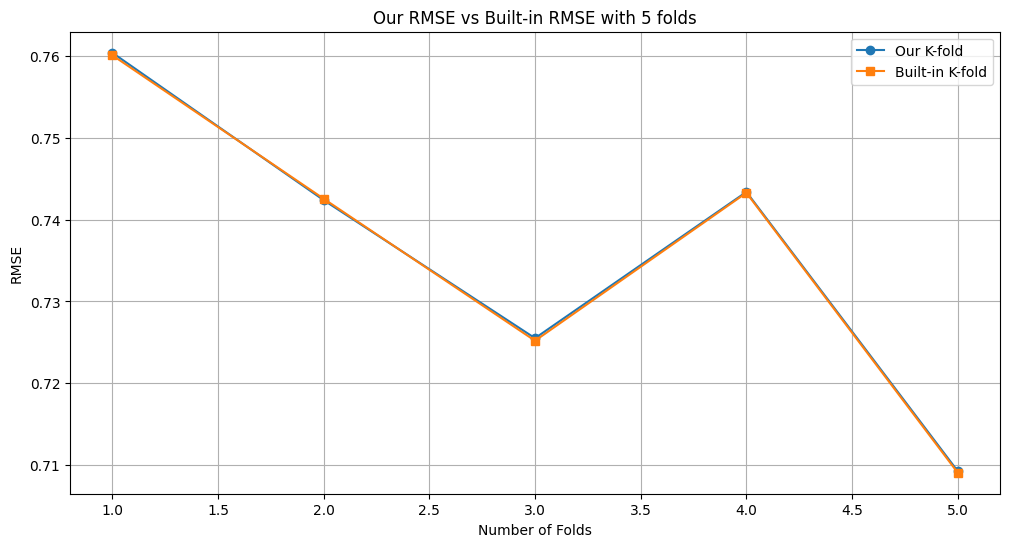

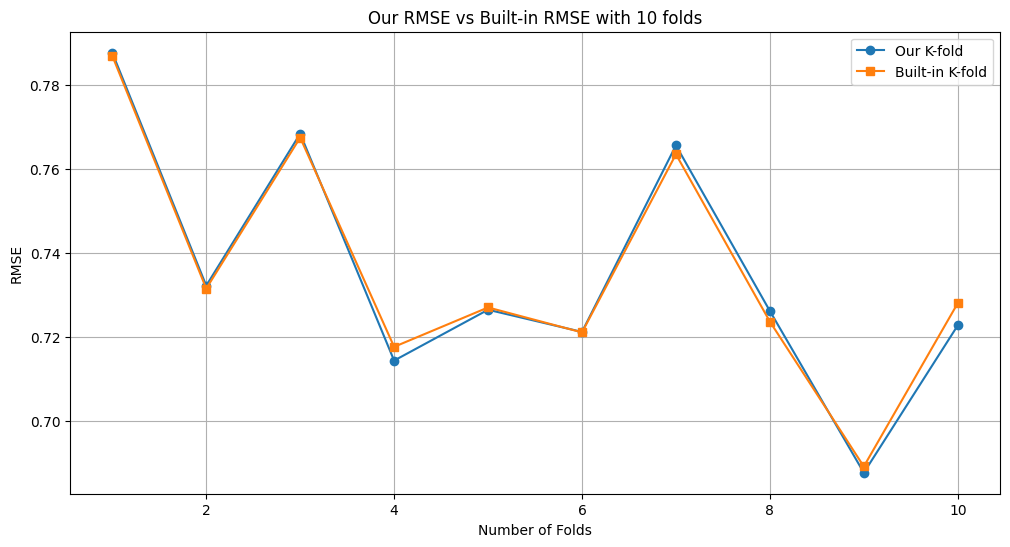

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), k_fold_results_5[0], marker='o', label='Our K-fold')
plt.plot(range(1, 6), rmse_scores_5, marker='s', label='Built-in K-fold')
plt.title('Our RMSE vs Built-in RMSE with 5 folds')
plt.xlabel('Number of Folds')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()  

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), k_fold_results_10[0], marker='o', label='Our K-fold')
plt.plot(range(1, 11), rmse_scores_10, marker='s', label='Built-in K-fold')
plt.title('Our RMSE vs Built-in RMSE with 10 folds')
plt.xlabel('Number of Folds')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show() 

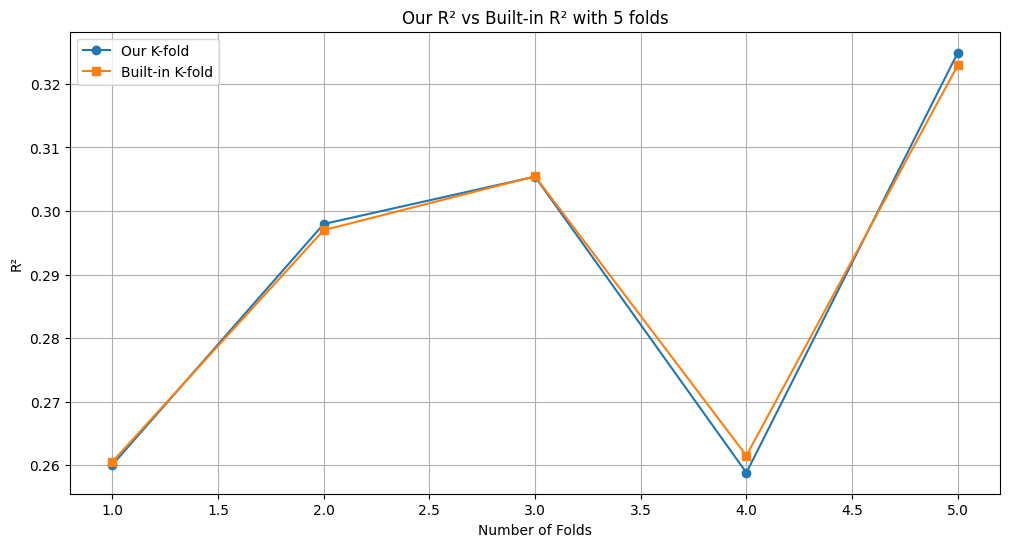

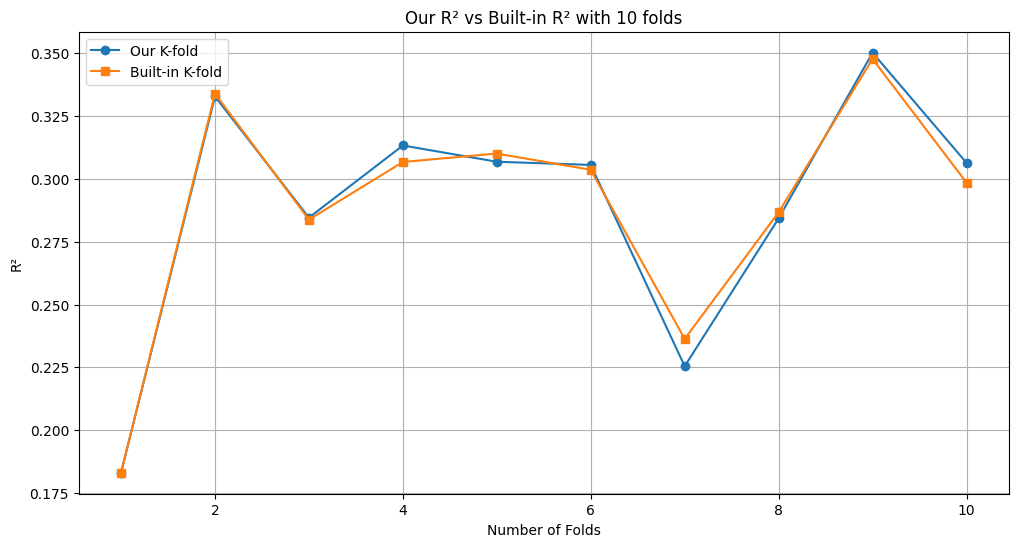

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), k_fold_results_5[1], marker='o', label='Our K-fold')
plt.plot(range(1, 6), r2_scores_5, marker='s', label='Built-in K-fold')
plt.title('Our R² vs Built-in R² with 5 folds')
plt.xlabel('Number of Folds')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()  

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), k_fold_results_10[1], marker='o', label='Our K-fold')
plt.plot(range(1, 11), r2_scores_10, marker='s', label='Built-in K-fold')
plt.title('Our R² vs Built-in R² with 10 folds')
plt.xlabel('Number of Folds')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show() 